## Functions to Wrangle the Zillow Data

### Import

In [41]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from env import host, user, password

import warnings
warnings.filterwarnings("ignore")

import sklearn.preprocessing

### Acquire Data

In [42]:
# Connect to SQL database
def get_db_url(db_name):
    '''
    This function contacts Codeup's SQL database and uses the info from 
    my env to create a connection URL.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [43]:
# Get Zillow data

def get_zillow_data():
    '''
    This function reads the zillow data from Codeup database to a dataframe,
    and returns the dataframe.
    '''
    # SQL query
    sql_query =  '''
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    LEFT JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")'''
    
    # Read in DataFrame
    df = pd.read_sql(sql_query, get_db_url('zillow'))
    
    df = df.rename(columns = {'bedroomcnt': 'num_beds',
                                      'bathroomcnt': 'num_baths',
                                      'calculatedfinishedsquarefeet': 'square_footage',
                                      'taxvaluedollarcnt': 'tax_value',
                                      'yearbuilt': 'year_built', 'taxamount': 'tax_amount', 'fips': 'county_code'})
    return df


In [44]:
df = get_zillow_data()
df.head()

,num_beds,num_baths,square_footage,tax_value,year_built,tax_amount,county_code
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


### Remove Outliers

In [45]:
# Function to remove outliers
def remove_outliers(df, k, col_list):
    ''' 
        This function removes outliers from a list of columns in a df
        then reurns that df. 
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe sans outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [46]:
split_df = df[['num_beds', 'num_baths', 'square_footage', 'tax_value']]

In [47]:
target = df.tax_value

### Visually Explore Individual Variables

In [48]:
def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['county_code', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()

In [49]:
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['num_beds', 'num_baths', 'square_footage', 'tax_value']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()

### Prepare Data

In [64]:
def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['num_beds', 'num_baths', 'square_footage', 'tax_value', 'year_built', 'tax_amount'])
    
    # Drop duplicates
    df = df.drop_duplicates()
    
    # Drop Columns
    # Drop this column to prevent leakage in model 
    df = df.drop(columns=['tax_amount'])
    
    # converting column datatypes
    #df.num_beds = df.num_beds.astype(object)
    #df.num_baths = df.num_baths.astype(object)
    #df.square_footage = df.square_footage.astype(object)
    df.year_built = df.year_built.astype(object)
    df.county_code = df.county_code.astype(object)
    
    # get distributions of numeric data
    # univariate explorstion before splitting
    get_hist(df)
    get_box(df)

    
    # train/validate/test split
    # splits the data for modeling and exploring, to prevent overfitting
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # Use train only to explore and for fitting
    # Only use validate to validate models after fitting on train
    # Only use test to test best model 
    return train, validate, test 

### Acquire, Prep, and Split

In [51]:
def wrangle_zillow():
    '''
    This function will both aquire and prepare the zillow data.
    It displays the histogram and boxplots before splitting the df.
    After running this function the data is ready for exploritory analysis.
    '''
    train, validate, test = prepare_zillow(get_zillow_data())
    
    return train, validate, test

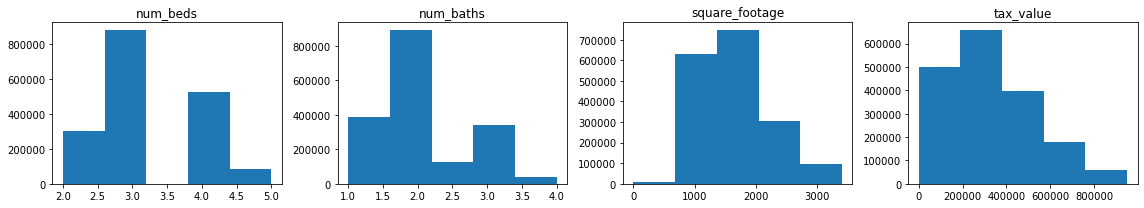

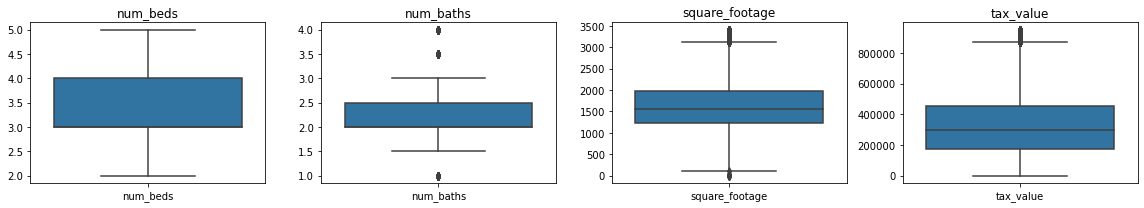

In [52]:
train, validate, test = wrangle_zillow()

In [55]:
train.head()

,num_beds,num_baths,square_footage,tax_value,year_built,county_code
1852198,4.0,2.0,1986.0,267140.0,1963.0,6111.0
126219,3.0,1.0,877.0,82067.0,1953.0,6059.0
855070,4.0,3.0,1972.0,159374.0,1942.0,6037.0
1569772,4.0,2.0,1309.0,497923.0,1956.0,6059.0
80997,3.0,2.0,1512.0,205712.0,1951.0,6037.0


In [56]:
train.shape

(1002739, 6)

In [57]:
validate.shape

(429746, 6)

In [58]:
test.shape

(358122, 6)

### Split into X and y variables

In [59]:
def split_tvt_into_variables(train, validate, test, target):

# split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target, 'year_built', 'county_code'])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target, 'year_built', 'county_code'])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target, 'year_built', 'county_code'])
    y_test = test[target]
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test


In [60]:
# Run split_tvt_into_variables / the target is tax_value
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_tvt_into_variables(train, validate, test, target='tax_value')

In [61]:
X_train.shape

(1002739, 3)

In [62]:
X_train.head()

,num_beds,num_baths,square_footage
1852198,4.0,2.0,1986.0
126219,3.0,1.0,877.0
855070,4.0,3.0,1972.0
1569772,4.0,2.0,1309.0
80997,3.0,2.0,1512.0


### Scaling Data

In [23]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    #Fit the thing
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    
    #transform the thing
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [24]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [25]:
X_train_scaled.shape

(1002739, 4)

In [26]:
def Standard_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs
    """

    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [27]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

In [28]:
X_train_scaled.shape

(1002739, 4)

### Visualize Data

In [29]:
#--------VISUALIZE THE SCALED DATA
def visualize_scaled_date(scaler, scaler_name, feature):
    scaled = scaler.fit_transform(train[[feature]])
    fig = plt.figure(figsize = (12,6))

    gs = plt.GridSpec(2,2)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])

    ax1.scatter(train[[feature]], scaled)
    ax1.set(xlabel = feature, ylabel = 'Scaled' + feature, title = scaler_name)

    ax2.hist(train[[feature]])
    ax2.set(title = 'Original')

    ax3.hist(scaled)
    ax3.set(title = 'Scaled')
    plt.tight_layout();

In [30]:
# visualize_scaled_date(sklearn.preprocessing.MinMaxScaler(), 'Min Max Scaler', 'num_beds')
